# Finding the Best Neighborhood in Pittsburgh: 
## Factoring in Property Values
Data borrowed from https://data.wprdc.org/dataset/real-estate-sales

### Getting Started

In [448]:
import pandas as pd
import geopandas
import numpy as np
import plotly

In [436]:
# Importing the data
property_data = pd.read_csv("PghPropertySaleData.csv", low_memory = False)

In [437]:
# Previewing the data
property_data.head(5)

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESSDIR,PROPERTYADDRESSSTREET,PROPERTYADDRESSSUF,PROPERTYADDRESSUNITDESC,PROPERTYUNITNO,PROPERTYCITY,PROPERTYSTATE,...,MUNIDESC,RECORDDATE,SALEDATE,PRICE,DEEDBOOK,DEEDPAGE,SALECODE,SALEDESC,INSTRTYP,INSTRTYPDESC
0,1075F00108000000,4720.0,,NaN,HIGHPOINT,DR,NaN,NaN,GIBSONIA,PA,...,Hampton,2012-09-27,2012-09-27,120000.0,15020,356,3,LOVE AND AFFECTION SALE,DE,DEED
1,0011A00237000000,0.0,,NaN,LOMBARD,ST,NaN,NaN,PITTSBURGH,PA,...,3rd Ward - PITTSBURGH,2015-01-06,2015-01-06,1783.0,TR15,00002,2,CITY TREASURER SALE,TS,TREASURER DEED
2,0011J00047000000,1903.0,,NaN,FORBES,AVE,NaN,NaN,PITTSBURGH,PA,...,1st Ward - PITTSBURGH,2012-10-26,2012-10-26,4643.0,TR13,003,2,CITY TREASURER SALE,TS,TREASURER DEED
3,0113B00029000000,479.0,,NaN,ROOSEVELT,AVE,NaN,NaN,PITTSBURGH,PA,...,Bellevue,2017-03-27,2017-03-06,0.0,16739,166,3,LOVE AND AFFECTION SALE,CO,CORRECTIVE DEED
4,0119S00024000000,5418.0,,NaN,CARNEGIE,ST,NaN,NaN,PITTSBURGH,PA,...,10th Ward - PITTSBURGH,2015-02-04,2015-02-04,27541.0,TR15,00059,GV,GOVERNMENT SALE,TS,TREASURER DEED


In [438]:
# In the preview, I noticed that the property in the fourth row sold for a price of $0.
# Looking through the .dbf file, I noticed that there are several other extremely low sold prices, such as $0, $1, and $10. 
# Therefore, I am only considering prices above $1,000 to mitigate the infuence of global outliers. 
property_data = property_data[property_data.PRICE > 1000]
# In importing the CSV file, the zip codes were turned into floats. This will cast them back into the int data type
property_data['PROPERTYZIP'] = property_data['PROPERTYZIP'].astype(int)

In [439]:
# Finding the mean of the property sold prices for all properties sharing the same zip code
price_property_data = property_data[['PROPERTYZIP','PRICE']].groupby(['PROPERTYZIP']).mean()
price_property_data

,PRICE
PROPERTYZIP,
15003,86601.668605
15005,529842.319527
15006,73238.805970
15007,172196.555556
15012,119375.000000
...,...
15642,90610.318182
15668,233826.666667
16046,408128.726704


In [440]:
# Rounding the mean property sales prices to the nearest dollar
price_property_data['PRICE'] = price_property_data['PRICE'].astype(int)
# Sorting the data by price
price_property_data.sort_values(by=['PRICE'],inplace=True)
price_property_data.head(10)

,PRICE
PROPERTYZIP,
15028,24032
15089,24272
15104,34736
15110,36851
15045,47284
15035,47925
15112,52032
15210,59941
15034,60619


### Establishing a points system and price brackets
Zip codes with properties within a certain threshold will be assigned a fixed number of points.          

Team members' data sets also utilize a point system.         

The neighborood with the highest combined number of points will be considered the best.

In [441]:
# First, price brackets need to be established. To do this, I will divide the distribution into five tiers, based on percentiles.

# Creating a new column called "Percentile Rank", which shows the percentage of prices that any one price is greater than.
price_property_data['Percentile Rank'] = price_property_data.PRICE.rank(pct = True)

In [442]:
# Now, I am creating conditions for the program to check in order to set a point value based on the Percentile Rank values. 

conditions = [
    (price_property_data['Percentile Rank'] <= .2),
    (price_property_data['Percentile Rank'] > .2) & (price_property_data['Percentile Rank'] <= .4),
    (price_property_data['Percentile Rank'] > .4) & (price_property_data['Percentile Rank'] <= .6),
    (price_property_data['Percentile Rank'] > .6) & (price_property_data['Percentile Rank'] <= .8),
    (price_property_data['Percentile Rank'] > .8)]
# The points work with the above conditions. If the first condition is met (percentile rank below .2), one point is assigned.
# If the second condition is met (percentile rank below or equal to .4 and greater than .2), then two poitns are assigned.
# This method gives more points to zip codes with higher percentile prices.
points = ['1', '2', '3', '4', '5']
# Making a new column called "Points" and adding point values based on the above conditions.
price_property_data['Points'] = np.select(conditions, points)
# Sorting the data first by points, and then by price.
price_property_data.sort_values(by=['Points', 'PRICE'],inplace=True)
price_property_data.head(5)

,PRICE,Percentile Rank,Points
PROPERTYZIP,,,
15028,24032,0.008547,1
15089,24272,0.017094,1
15104,34736,0.025641,1
15110,36851,0.034188,1
15045,47284,0.042735,1


### Visualizing the data

In [449]:
price_property_data = price_property_data.astype(str)
price_property_data = price_property_data.reset_index()
conditions2 = [
    (price_property_data['PROPERTYZIP'] == '15028'),
    (price_property_data['PROPERTYZIP'] == '15089'),
    (price_property_data['PROPERTYZIP'] == '15104'),
    (price_property_data['PROPERTYZIP'] == '15110'),
    (price_property_data['PROPERTYZIP'] == '15045'),
    (price_property_data['PROPERTYZIP'] != '15089')]

points2 = ['Central Oakland', 'North Oakland', 'West Oakland', 'Crawford-Roberts', 'Strip District', 'Central Business District
           ']

price_property_data['neighborhood'] = np.select(conditions2, points2)

price_property_data.head(119)

,index,PROPERTYZIP,PRICE,Percentile Rank,Points,neighborhood
0,0,15028,24032,0.008547008547008548,1,Central Oakland
1,1,15089,24272,0.017094017094017096,1,North Oakland
2,2,15104,34736,0.02564102564102564,1,South Oakland
3,3,15110,36851,0.03418803418803419,1,Squirrel Hill
4,4,15045,47284,0.042735042735042736,1,Squirrel Hill South
...,...,...,...,...,...,...
112,112,15142,570302,0.9658119658119658,5,test
113,113,15086,911245,0.9743589743589743,5,test
114,114,15222,1274521,0.9829059829059829,5,test
115,115,15276,1850783,0.9914529914529915,5,test


,hood,PRICE,geometry
0,Central Oakland,NaN,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."
1,North Oakland,NaN,"POLYGON ((-79.95455 40.45882, -79.95427 40.458..."
2,West Oakland,NaN,"POLYGON ((-79.96230 40.44294, -79.96220 40.442..."
3,Crawford-Roberts,NaN,"POLYGON ((-79.98275 40.44641, -79.98273 40.446..."
4,Strip District,NaN,"POLYGON ((-79.97494 40.45629, -79.97484 40.456..."
5,Central Business District,NaN,"POLYGON ((-79.99238 40.44484, -79.99233 40.444..."
6,Spring Hill-City View,NaN,"POLYGON ((-79.99761 40.47460, -79.99761 40.474..."
7,Perry South,NaN,"POLYGON ((-80.01456 40.47727, -80.01462 40.477..."
8,Summer Hill,NaN,"POLYGON ((-80.01087 40.50097, -80.01073 40.499..."
9,Northview Heights,NaN,"POLYGON ((-80.00327 40.48271, -80.00326 40.482..."


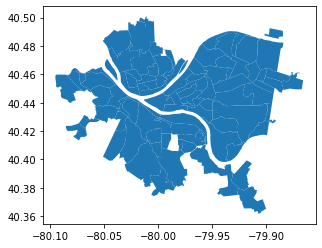

In [444]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
neighborhoods.plot()
property_values_map = neighborhoods.merge(price_property_data, how='left', left_on='hood',right_on='neighborhood')
property_values_map[['hood','PRICE','geometry']].head(50)

IndexError: index 0 is out of bounds for axis 0 with size 0

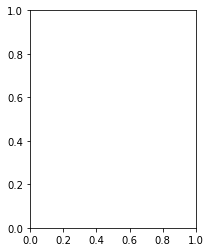

In [445]:
property_values_map.plot(column='PRICE')